# Intro to Argovis' Grid API

Argovis offers a growing list of gridded products, indexed and downloadable through its API. In this notebook, we'll illustrate some basic operations and handling of this data.

> **This is a beta product!**
> Argovis' new API is currently undergoing heavy development. Therefore, everything in these notebooks should be understood as a technical preview only; implementation details may change before a 
stable release is made. Please send feedback and ideas to argovis@colorado.edu, and see the API docs as they evolve at https://argovis-api.colorado.edu/docs/.

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for `API_KEY` in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
import requests, xarray, pandas, math, datetime, copy
import numpy as np
from datetime import datetime, timedelta
from argovisHelpers import helpers as avh

API_KEY=''
API_PREFIX = 'https://argovisbeta01.colorado.edu/api/'

## Downloading Gridded Data

Argovis supports a number of grids through the same API endpoints. Let's begin by discovering what grids are available:

In [2]:
grids = avh.query('grids/vocabulary', options={'parameter':'gridName'}, apikey=API_KEY, apiroot=API_PREFIX)
grids

[{'grid_1_1_0.5_0.5': {'grids': ['rg09_temperature',
    'rg09_salinity',
    'kg21_ohc15to300'],
   'lattice': [[-179.5, -64.5],
    [-179.5, -63.5],
    [-179.5, -62.5],
    [-179.5, -61.5],
    [-179.5, -60.5],
    [-179.5, -59.5],
    [-179.5, -58.5],
    [-179.5, -57.5],
    [-179.5, -56.5],
    [-179.5, -55.5],
    [-179.5, -54.5],
    [-179.5, -53.5],
    [-179.5, -52.5],
    [-179.5, -51.5],
    [-179.5, -50.5],
    [-179.5, -49.5],
    [-179.5, -48.5],
    [-179.5, -47.5],
    [-179.5, -46.5],
    [-179.5, -45.5],
    [-179.5, -44.5],
    [-179.5, -43.5],
    [-179.5, -42.5],
    [-179.5, -41.5],
    [-179.5, -40.5],
    [-179.5, -39.5],
    [-179.5, -38.5],
    [-179.5, -37.5],
    [-179.5, -36.5],
    [-179.5, -35.5],
    [-179.5, -34.5],
    [-179.5, -33.5],
    [-179.5, -32.5],
    [-179.5, -31.5],
    [-179.5, -30.5],
    [-179.5, -29.5],
    [-179.5, -28.5],
    [-179.5, -27.5],
    [-179.5, -26.5],
    [-179.5, -25.5],
    [-179.5, -24.5],
    [-179.5, -23.5],
    [-179

We get an object whose keys represent the different grid lattices available, such as `grid_1_1_0.5_0.5` (a 1 degree longitude by 1 degree latitude grid centered on 0.5, 0.5), what data products are available on that lattice, and what the lattice points with nonzero data are. We can query data from any one of these via the `/grids/{gridName}` route, and the usual temporospatial parameters that may be familiar from other Argovis APIs:

 - `startDate` (geo-constrained, see below, format YYYY-MM-DDTHH:MM:SSZ at GMT0): beginning of time window to query.
 - `endDate` (geo-constrained, see below, format YYYY-MM-DDTHH:MM:SSZ at GMT0): end of time window to query.
 - `polygon` (geo-constrained, see below, format [[lon0,lat0],[lon1,lat1],...,[lonN,latN],[lon0,lat0]]): geographical region to query.
 - `multipolygon` (geo-constrained, see below, format as a list of `polygon`s): query the geographical region at the intersection of *all* listed polygons.
 - `center` + `radius` (geo-constrained, see below, center format lon,lat ; raidus format distance in km): geographical region to query, defined as maximum distance (radius) from a point (center).
 - `presRange` (optional, format shallowlimit,deeplimit): only return levels between the limits specified, in dbar.
 - `data` (optional, format comma separated list of keys): request the actual measurements to go with matched documents.
 
**Items marked 'geo-constrained'** are individually optional, but have soft limits based on estimates of how much data they will return. If you need to query a large area, consider making requests over a short timespan; or vice versa.

Let's try a simple request to download a piece of data from one of these grids, the North Atlantic from the first quarter of 2012 from the Roemmich-Gilson Argo temperature climatology. For gridded data, the `data` key, when used, always matches the grid name in the route.

In [3]:
params = {
  "startDate": '2012-01-01T00:00:00Z',
  "endDate": '2012-04-01T00:00:00Z',
  "polygon": '[[-49.92187499999999,56.17002298293205],[-48.1640625,49.61070993807422],[-56.6015625,42.5530802889558],[-72.421875,35.746512259918504],[-72.421875,27.059125784374068],[-47.4609375,26.115985925333536],[-19.6875,27.371767300523047],[-12.65625,36.59788913307022],[-11.6015625,46.558860303117164],[-13.0078125,56.75272287205736],[-49.92187499999999,56.17002298293205]]',
  "data": 'rg09_temperature'
}

rgdata = avh.query('grids/grid_1_1_0.5_0.5', options=params, apikey=API_KEY, apiroot=API_PREFIX)

(If you need help constructing a polygon, try the following:

  - visit argovis.colorado.edu
  - draw a shape
  - click on the purple shaded area of the region of interest (not on a dot)
  - from the pop up window, go "to Selection page"
  - from the url of the selection shape, copy the shape, i.e. [copy_all_this_inside_outer_brackets] after 'shape=')


Like most Argovis API requests, you get a list of documents matching your query. Let's have a look at the first record in what the API returned to us:

In [4]:
rgdata[0]

{'_id': '20120315000000_-67.5_27.5',
 'metadata': {'rg09_temperature': 'rg09_temperature_200401_Total'},
 'geolocation': {'type': 'Point', 'coordinates': [-67.5, 27.5]},
 'basin': 1,
 'timestamp': '2012-03-15T00:00:00.000Z',
 'data_keys': ['rg09_temperature'],
 'units': {'rg09_temperature': 'degree celcius (ITS-90)'},
 'data': {'rg09_temperature': [22.513,
   22.505001,
   22.532,
   22.517,
   22.469,
   22.427,
   22.407,
   22.358,
   22.219999,
   22.004,
   21.593,
   21.268999,
   21.033001,
   20.812,
   20.59,
   20.314001,
   20.013,
   19.764999,
   19.486,
   19.150999,
   18.974001,
   18.832001,
   18.692999,
   18.552,
   18.423,
   18.323,
   18.219,
   18.105999,
   17.993,
   17.875,
   17.726,
   17.561001,
   17.337,
   16.910999,
   16.209999,
   15.365,
   14.434999,
   13.397,
   12.301,
   11.073,
   9.86,
   8.798,
   7.939,
   7.338,
   6.793,
   6.306,
   5.925,
   5.635,
   5.396,
   5.174,
   5.001,
   4.813,
   4.606,
   4.401,
   4.16,
   3.969,
   3.826,


By default, Argovis returns gridded data in a *profile-like* structure, with a schema similar to other Argovis APIs. The most important difference between gridded data and everything else, is the `data` key: for grids, `data[i][j]` represents the jth level from the ith data product, where i counts over the `data_keys` entry in the same document. Data is presented in the `data` key, with units for each key presented in the `units` property. Since a grid reports values at regular depths, those depths are reported in the metdata document associated with each grid profile in order to avoid trasmitting them over and over for default requests like this. We can look them up using the `/grids/metadata` route and the `metadata` key from the document in question, taking care to select the metadata that corresponds to the data product of interest (`rg09_temperature` in this case):

In [5]:
metadata_params = {
    "id": rgdata[0]['metadata']['rg09_temperature']
}

rgmeta = avh.query('grids/meta', options=metadata_params, apikey=API_KEY, apiroot=API_PREFIX)
rgmeta

[{'_id': 'rg09_temperature_200401_Total',
  'data_type': 'temperature',
  'date_updated_argovis': '2023-01-09T15:58:13.670Z',
  'source': [{'source': ['Roemmich-Gilson Argo Climatology'],
    'url': 'https://sio-argo.ucsd.edu/gilson/argo_climatology/RG_ArgoClim_Temperature_2019.nc.gz'}],
  'levels': [2.5,
   10,
   20,
   30,
   40,
   50,
   60,
   70,
   80,
   90,
   100,
   110,
   120,
   130,
   140,
   150,
   160,
   170,
   182.5,
   200,
   220,
   240,
   260,
   280,
   300,
   320,
   340,
   360,
   380,
   400,
   420,
   440,
   462.5,
   500,
   550,
   600,
   650,
   700,
   750,
   800,
   850,
   900,
   950,
   1000,
   1050,
   1100,
   1150,
   1200,
   1250,
   1300,
   1350,
   1412.5,
   1500,
   1600,
   1700,
   1800,
   1900,
   1975]}]

Here we see some interesting metadata about the file that produced the first record in our list of grid estimates, including the levels by which we can interpret the `data` key: these lists are sorted identically, so the first element in a `data` list corresponds to a depth of 2.5 dbar, the first entry in the corresponding `levels` metadata key.

If we're only interested in the grid estimates near the ocean surface, we can add a `presRange` filter to our data request:

In [6]:
filter_params = copy.deepcopy(params)
filter_params['presRange'] = '0,100'

rgSurfacedata = avh.query('grids/grid_1_1_0.5_0.5', options=filter_params, apikey=API_KEY, apiroot=API_PREFIX)
rgSurfacedata[0]

{'_id': '20120315000000_-67.5_27.5',
 'metadata': {'rg09_temperature': 'rg09_temperature_200401_Total'},
 'geolocation': {'type': 'Point', 'coordinates': [-67.5, 27.5]},
 'basin': 1,
 'timestamp': '2012-03-15T00:00:00.000Z',
 'data_keys': ['rg09_temperature'],
 'units': {'rg09_temperature': 'degree celcius (ITS-90)'},
 'data': {'rg09_temperature': [22.513,
   22.505001,
   22.532,
   22.517,
   22.469,
   22.427,
   22.407,
   22.358,
   22.219999,
   22.004,
   21.593]},
 'levels': {'rg09_temperature': [2.5,
   10,
   20,
   30,
   40,
   50,
   60,
   70,
   80,
   90,
   100]}}

Now our data records returned by the `grids/grid_1_1_0.5_0.5` route only report levels within the range requested; also note when we customize the depth range requested, the custom-filtered list of levels appears directly on the data document. **When a key, such as levels, appears on a data document and that document's corresponding metadata document, the assigned value on the data document always takes precedence**.

When downloading large volumes of data, we can also request that it be minified:

In [7]:
mini_params = copy.deepcopy(params)
mini_params['compression'] = 'array'

rgdata = avh.query('grids/grid_1_1_0.5_0.5', options=mini_params, apikey=API_KEY, apiroot=API_PREFIX)
rgdata[0]

{'_id': '20120315000000_-67.5_27.5',
 'metadata': ['rg09_temperature_200401_Total'],
 'geolocation': {'type': 'Point', 'coordinates': [-67.5, 27.5]},
 'basin': 1,
 'timestamp': '2012-03-15T00:00:00.000Z',
 'data_keys': ['rg09_temperature'],
 'units': ['degree celcius (ITS-90)'],
 'data': [[22.513,
   22.505001,
   22.532,
   22.517,
   22.469,
   22.427,
   22.407,
   22.358,
   22.219999,
   22.004,
   21.593,
   21.268999,
   21.033001,
   20.812,
   20.59,
   20.314001,
   20.013,
   19.764999,
   19.486,
   19.150999,
   18.974001,
   18.832001,
   18.692999,
   18.552,
   18.423,
   18.323,
   18.219,
   18.105999,
   17.993,
   17.875,
   17.726,
   17.561001,
   17.337,
   16.910999,
   16.209999,
   15.365,
   14.434999,
   13.397,
   12.301,
   11.073,
   9.86,
   8.798,
   7.939,
   7.338,
   6.793,
   6.306,
   5.925,
   5.635,
   5.396,
   5.174,
   5.001,
   4.813,
   4.606,
   4.401,
   4.16,
   3.969,
   3.826,
   3.699]]}

## Ingestion by xarray

Xarray is a familiar pythonic data structure; we can transform a raw API response to an xarray with a helper similar to the following.

In [8]:
rgdata

[{'_id': '20120315000000_-67.5_27.5',
  'metadata': ['rg09_temperature_200401_Total'],
  'geolocation': {'type': 'Point', 'coordinates': [-67.5, 27.5]},
  'basin': 1,
  'timestamp': '2012-03-15T00:00:00.000Z',
  'data_keys': ['rg09_temperature'],
  'units': ['degree celcius (ITS-90)'],
  'data': [[22.513,
    22.505001,
    22.532,
    22.517,
    22.469,
    22.427,
    22.407,
    22.358,
    22.219999,
    22.004,
    21.593,
    21.268999,
    21.033001,
    20.812,
    20.59,
    20.314001,
    20.013,
    19.764999,
    19.486,
    19.150999,
    18.974001,
    18.832001,
    18.692999,
    18.552,
    18.423,
    18.323,
    18.219,
    18.105999,
    17.993,
    17.875,
    17.726,
    17.561001,
    17.337,
    16.910999,
    16.209999,
    15.365,
    14.434999,
    13.397,
    12.301,
    11.073,
    9.86,
    8.798,
    7.939,
    7.338,
    6.793,
    6.306,
    5.925,
    5.635,
    5.396,
    5.174,
    5.001,
    4.813,
    4.606,
    4.401,
    4.16,
    3.969,
    3.8

In [9]:
rgmeta[0]['levels']

[2.5,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 182.5,
 200,
 220,
 240,
 260,
 280,
 300,
 320,
 340,
 360,
 380,
 400,
 420,
 440,
 462.5,
 500,
 550,
 600,
 650,
 700,
 750,
 800,
 850,
 900,
 950,
 1000,
 1050,
 1100,
 1150,
 1200,
 1250,
 1300,
 1350,
 1412.5,
 1500,
 1600,
 1700,
 1800,
 1900,
 1975]

In [10]:
def xargrid(grid, depths):
    # given the json response <grid> of a request to /grids/{gridName} and a single gridded product,
    # a list <depths> of the corresponding depths for these grid documents
    # return an xarray object with coordinates time, lat, lon, depth, and measurement value.
    
    lat = []
    lon = []
    time = []
    meas = []
    pressure = []
    for p in grid:
        for i, e in enumerate(p['data'][0]):
            lon.append(p['geolocation']['coordinates'][0])
            lat.append(p['geolocation']['coordinates'][1])
            time.append(avh.parsetime(p['timestamp']))
            meas.append(p['data'][0][i])
            pressure.append(depths[i])
            
    df = pandas.DataFrame({"latitude": lat, 
                           "longitude": lon, 
                           "time": time, 
                           "pressure": pressure, 
                           "measurement": meas}).set_index(["latitude","longitude","time","pressure"])
    return df.to_xarray()
    
ds = xargrid(rgdata, rgmeta[0]['levels'])

Now we can do all the usual xarray operations; lets see what the ranges of our coordinate variables are:

In [11]:
print('latitudes:',ds['latitude'].data)
print('longitudes:',ds['longitude'].data)
print('times:',ds['time'].data)
print('pressures:',ds['pressure'].data)

latitudes: [26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5
 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5
 54.5 55.5 56.5 57.5]
longitudes: [-71.5 -70.5 -69.5 -68.5 -67.5 -66.5 -65.5 -64.5 -63.5 -62.5 -61.5 -60.5
 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 -51.5 -50.5 -49.5 -48.5
 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5 -41.5 -40.5 -39.5 -38.5 -37.5 -36.5
 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5 -29.5 -28.5 -27.5 -26.5 -25.5 -24.5
 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5]
times: ['2012-01-15T00:00:00.000000000' '2012-02-15T00:00:00.000000000'
 '2012-03-15T00:00:00.000000000']
pressures: [   2.5   10.    20.    30.    40.    50.    60.    70.    80.    90.
  100.   110.   120.   130.   140.   150.   160.   170.   182.5  200.
  220.   240.   260.   280.   300.   320.   340.   360.   380.   400.
  420.   440.   462.5  500.   550.   600.   650.   700.   750.   800.
  850.   900.   950.  1000.  1050.  1100.  1150.  

We can easily select a slice of this array at constant pressure and time, to produce a possibly more conventional, map-like grid representation, and plot it with xarray's built in plots:

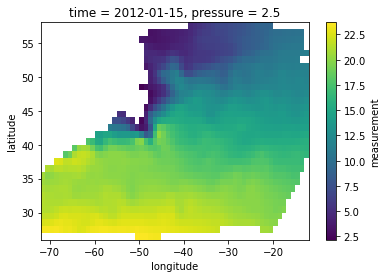

In [12]:
gridmap = ds.loc[{"time":'2012-01-15T00:00:00.000Z', "pressure":2.5}]
gridmap['measurement'].plot()

## Area-Weighted Means over a longitude/latitude region

A common operation when considering gridded data is to weight a mean by area of grid cells, which changes with latitude. A helper to do this with Argovis grid data could look like the following.

In [13]:
def areaweighted_region_mean(dxr):
    # given an xarray dataset <grid> for a given depth and time,
    # calculate the mean of the gridded data variable, weighted by grid cell area
    weights = np.cos(np.deg2rad(dxr.latitude))
    weights.name = "weights"
    dxr_weighted = dxr.weighted(weights)
    
    return dxr_weighted.mean(("longitude", "latitude"))

In [14]:
dxr_aw = areaweighted_region_mean(dxr=ds)
print(dxr_aw.loc[{"time":'2012-01-15T00:00:00.000Z', "pressure":2.5}])
dxr_aw

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    time         datetime64[ns] 2012-01-15
    pressure     float64 2.5
Data variables:
    measurement  float64 16.27


<xarray.Dataset>
Dimensions:      (time: 3, pressure: 58)
Coordinates:
  * time         (time) datetime64[ns] 2012-01-15 2012-02-15 2012-03-15
  * pressure     (pressure) float64 2.5 10.0 20.0 ... 1.8e+03 1.9e+03 1.975e+03
Data variables:
    measurement  (time, pressure) float64 16.27 16.28 16.28 ... 3.888 3.772

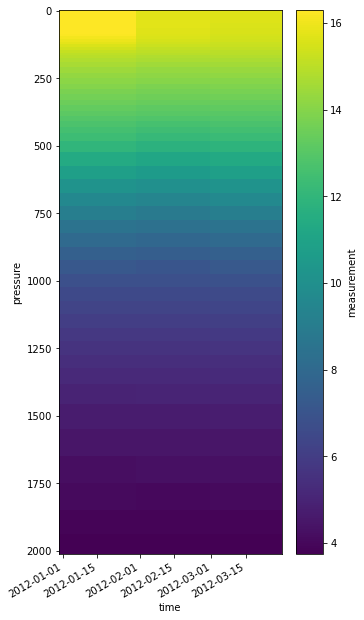

In [15]:
# Let's plot the data after the spatial average over longitude and latitude
dxr_aw['measurement'].plot(y="pressure",yincrease=False,aspect=0.5, size=10)

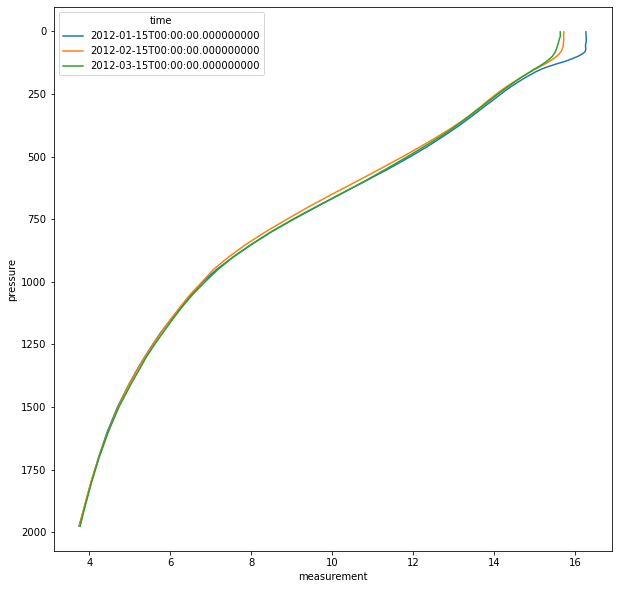

In [16]:
# Let's plot the data again, this time plotting one line per timestep
dxr_aw['measurement'].plot.line(y="pressure",yincrease=False,aspect=1, size=10)

## Accessing and visualizing Ocean Heat Content (OHC)

OHC fields in the following are by Kuusela and Giglio 2022 (https://doi.org/10.5281/zenodo.6131625) and are mapped using locally stationary Gaussian processes with data-driven decorrelation scales (Kuusela and Stein, 2018). A linear time trend was included in the estimate of the mean field (along with spatial terms and harmonics for the annual cycle). Mapping is done in latitude and longitude with monthly subsets of data for e.g. the 15-300 dbar pressure layer. The top layer of the pressure range is indicated in "levels".

In [17]:
params = {
  "startDate": '2012-01-01T00:00:00Z',
  "endDate": '2013-01-01T00:00:00Z',
  "polygon": '[[-78,30],[-70,30],[-70,20],[-78,20],[-78,30]]',
  "data": 'kg21_ohc15to300',
  "compression": "array"
}
ohc_kg = avh.query('grids/grid_1_1_0.5_0.5', options=params, apikey=API_KEY, apiroot=API_PREFIX)

metadata_params = {
    "id": ohc_kg[0]['metadata'][0]
}
ohcmeta = avh.query('grids/meta', options=metadata_params, apikey=API_KEY, apiroot=API_PREFIX)

In [18]:
ds_ohc = xargrid(ohc_kg, ohcmeta[0]['levels'])

In [19]:
ds_ohc

<xarray.Dataset>
Dimensions:      (latitude: 10, longitude: 8, time: 12, pressure: 1)
Coordinates:
  * latitude     (latitude) float64 20.5 21.5 22.5 23.5 ... 26.5 27.5 28.5 29.5
  * longitude    (longitude) float64 -77.5 -76.5 -75.5 ... -72.5 -71.5 -70.5
  * time         (time) datetime64[ns] 2012-01-15 2012-02-15 ... 2012-12-15
  * pressure     (pressure) int64 15
Data variables:
    measurement  (latitude, longitude, time, pressure) float64 nan ... 3.439e+11

Let's plot a map of OHC for January 2012:

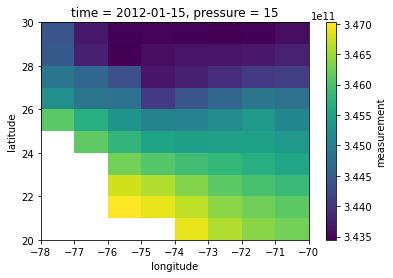

In [20]:
gridmap = ds_ohc.loc[{"time":'2012-01-15T00:00:00.000Z',"pressure":15}]
gridmap['measurement'].plot()

Let's now compute the area average in the selected region.

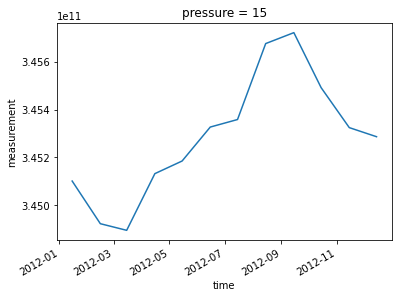

In [21]:
dxr_aw_ohc = areaweighted_region_mean(dxr=ds_ohc)
dxr_aw_ohc['measurement'].plot()